# Cats 'n Dogs
Case study with TensorFlow 2.0 (Keras) to demonstrate Transfer Learning and Fine Tunning.

When dataset is ... do ...
- ... **large** and **different** do full-network training
- ... **large** and **similar** do fine tunning
- ... **small** and **different** do fine tunning
- ... **small** and **similar** do transfer learning

In [2]:
import os
import zipfile
import numpy as np
import matplotlib.pyplot as plt
import datetime
from time import localtime, strftime
from tqdm import tqdm_notebook
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator


%matplotlib inline
tf.__version__

'2.0.0-alpha0'

## Preprocessing
Downloading, unzipping and setting up dataset paths in preparation to processing; exploring data and finally rescaling.

In [3]:
#download dataset
!wget --no-check-certificate \
      https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
      -O ./cats_and_dogs_filtered.zip

--2019-08-15 08:04:08--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 216.58.214.176, 2a00:1450:4003:803::2010
Connecting to storage.googleapis.com (storage.googleapis.com)|216.58.214.176|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘./cats_and_dogs_filtered.zip’

./cats_and_dogs_fil 100%[===================>]  65.43M  1.79MB/s    in 37s     

2019-08-15 08:04:46 (1.76 MB/s) - ‘./cats_and_dogs_filtered.zip’ saved [68606236/68606236]



In [4]:
#unzip dataset
dataset_path = "./cats_and_dogs_filtered.zip"
zip_object = zipfile.ZipFile(file=dataset_path, mode="r")
zip_object.extractall("./")
zip_object.close()

In [5]:
#setup dataset paths
dataset_path_new = "./cats_and_dogs_filtered/"
train_dir = os.path.join(dataset_path_new, "train")
validation_dir = os.path.join(dataset_path_new, "validation")

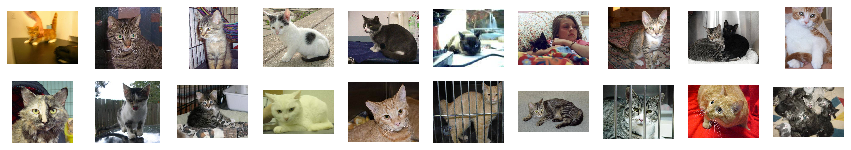

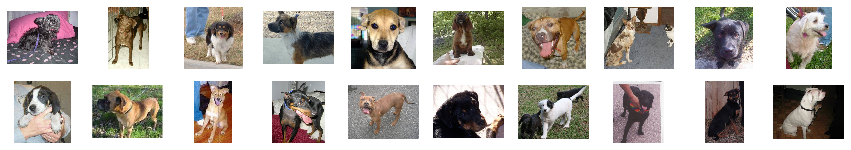

In [6]:
#explore dataset
fig, ax = plt.subplots(2,10, figsize=(15,2.5))
for (i,j) in [(i,j) for i in range(2) for j in range(10)]:
    img = plt.imread( os.path.join(train_dir,"cats/cat."+str(10*i+j)+".jpg") )
    ax[i,j].imshow( img )
    ax[i,j].axis('off')
plt.show()

#explore dataset
fig, ax = plt.subplots(2,10, figsize=(15,2.5))
for (i,j) in [(i,j) for i in range(2) for j in range(10)]:
    img = plt.imread( os.path.join(train_dir,"dogs/dog."+str(10*i+j)+".jpg") )
    ax[i,j].imshow( img )
    ax[i,j].axis('off')
plt.show()

In [ ]:
#preprocessing with data generators
data_gen_train = ImageDataGenerator(rescale=1/255.)
data_gen_valid = ImageDataGenerator(rescale=1/255.)

train_generator = data_gen_train.flow_from_directory(train_dir, target_size=(128,128), batch_size=128, class_mode="binary")
valid_generator = data_gen_valid.flow_from_directory(validation_dir, target_size=(128,128), batch_size=128, class_mode="binary")

## Pretrained Model
Loading of pretrained model, freezing of base model and definition of new head for the custom network.

In [7]:
#loading: MobileNetV2
IMG_SHAPE = (128, 128, 3)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE, include_top=False, weights="imagenet")
base_model.summary()

Model: "mobilenetv2_1.00_128"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 129, 129, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 64, 64, 32)   864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalizationV1) (None, 64, 64, 32)   128         Conv1[0][0]                      
_______________________________________________________________________________

In [8]:
#Freezing
base_model.trainable = False

The last layer of the base model `base_model.output` has size `(None, 4, 4, 1280)`. To proceed into constructing the new head, one could flatten this layer to reshape it into a vector and then define a new output layer for the total network, but the flattening would result in a very long vector of size `4x4x1280`. Since at this point the size of the activations is just `4x4`, it may suffice to summarize their information into a single statistic such as an average. Doing so, would result in a vector of size `1280`.

To finish up the head, the output layer of our custom network is then defined to output a "probability" for (one of) our two classes.

In [ ]:
#New Head
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
prediction_layer = tf.keras.layers.Dense(units=1, activation='sigmoid')(global_average_layer)

## Model Construction
Convolutional neural network using transfer learning and fine tunning.

### Architecture and Optimization Strategy
Combination of the base model and the custom head. Learning will use RMS optimizer, with binary cross entropy as loss and accuracy as performance metric.

[ https://stackoverflow.com/questions/44477489/keras-difference-between-categorical-accuracy-and-sparse-categorical-accuracy ]

In [19]:
#---[ Architecture ]------------------------------------------------------
#network
model = tf.keras.models.Model(inputs=base_model.input, outputs=prediction_layer)


#---[ Optimization Strategy ]------------------------------------------------------
##initial_learning_rate = 0.0001
##
##lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
##    initial_learning_rate,
##    decay_steps=1000,
##    decay_rate=0.96,
##    staircase=True)
##
##RMSpropdecay = tf.keras.optimizers.RMSprop(learning_rate=lr_schedule)*/
##model.compile( optimizer=RMSpropdecay, ... )

model.compile( optimizer=tf.keras.optimizers.RMSprop(lr=0.0001),
               loss="binary_crossentropy",
               metrics=["accuracy"] )


model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 129, 129, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 64, 64, 32)   864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalizationV1) (None, 64, 64, 32)   128         Conv1[0][0]                      
____________________________________________________________________________________________

### Training
Five epochs in batch mode.

In [ ]:
#tensorboard_cbk = tf.keras.callbacks.TensorBoard(
#  log_dir='./cifar10_tb/' + strftime( "%Y%b%dT%Hh%M", localtime() ).lower() + '/',
#  histogram_freq=1,  # How often to log histogram visualizations
#  embeddings_freq=1,  # How often to log embedding visualizations
#  update_freq='epoch' # How often to write logs (default: once per epoch)
#)
#?????? callbacks=[tensorboard_cbk] in model.fit_generator

numepochs = 5
#?????? history = model.fit_generator(...)
model.fit_generator( train_generator
                     epochs=numepochs,
                     validation_data=valid_generator)

#transfer learning model evaluation
valid_loss, valid_accuracy = model.evaluate_generator(valid_generator)
print("Accuracy after transfer learning: {}".format(valid_accuracy))



Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Epoch 1/5


In [ ]:
history_dict = history.history
#print(history_dict.keys())

acc = history_dict['sparse_categorical_accuracy']
val_acc = history_dict['val_sparse_categorical_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

fig, axes = plt.subplots(1,2, figsize=(13,5))
axes[0].set_title('Training and validation loss')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Loss')
axes[0].plot(epochs, loss, 'bo', label='Training loss')
axes[0].plot(epochs, val_loss, 'b-', label='Validation loss')
axes[0].set_xticks([i for i in range(0,len(epochs)+1)])
axes[0].xaxis.set_major_locator(plt.MultipleLocator(5))
axes[0].legend()

axes[1].set_title('Training and validation accuracy')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Accuracy')
axes[1].plot(epochs, acc, 'bo', label='Training acc')
axes[1].plot(epochs, val_acc, 'b', label='Validation acc')
axes[1].set_xticks([i for i in range(0,len(epochs)+1)])
axes[1].xaxis.set_major_locator(plt.MultipleLocator(5))
axes[1].legend()

fig.tight_layout()
plt.subplots_adjust(wspace=0.25)
plt.show()

## Fine Tuning
There are a few pointers:

* DO NOT use Fine tuning on the whole network; only a few top layers are enough. In most cases, they are more specialized. The goal of the Fine-tuning is to adopt that specific part of the network for our custom (new) dataset.

* Start with the fine tunning AFTER you have finished with transfer learning step. If we try to perform Fine tuning immediately, gradients will be much different between our custom head layer and a few unfrozen layers from the base model.

In [ ]:
#unfreeze a few top layers from the model
print("Number of layers in the base model: {}".format(len(base_model.layers)))

base_model.trainable = True
fine_tune_at = 100

for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

In [ ]:
#compile model for fine-tunning
model.compile( optimizer=tf.keras.optimizers.RMSprop(lr=0.0001),
               loss='binary_crossentropy',
               metrics=['accuracy'])

In [ ]:
#fine tunning
#history = model.fit_generator(...)
model.fit_generator( train_generator,  
                     epochs=5, 
                     validation_data=valid_generator)

## Evaluation and Prediction
Finally, the (approximated) model is evaluated using the test dataset.

In [ ]:
valid_loss, valid_accuracy = model.evaluate_generator(valid_generator)

print("Validation accuracy after fine tuning: {}".format(valid_accuracy))

### If all went well...
...save the model.

In [ ]:
#save architecture
model_json = model.to_json()
with open("catsndogs.json","w") as jsonfile:
    jsonfile.write(model_json)

#save weights
model.save_weights("catsndogs_model.h5")